# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


In [ ]:
# !pip install contractions
# !pip install torchtext

# Loading dataset

In [2]:
root = os.getcwd()
#yelp polarity has 2 labels, 
#yelp dataset has 5 labels, they have the same text content
train_datapath = os.path.join(root, 'dataset', 'yelp_polarity', 'train.csv') 
test_datapath = os.path.join(root,  'dataset', 'yelp_polarity', 'test.csv') 

assert os.path.exists(train_datapath),  f"train dataset path {train_datapath} not found"
assert os.path.exists(test_datapath),   f"test dataset path {test_datapath} not found"

sample_size = 0.1

In [3]:
train_df = pd.read_csv(train_datapath, names = ["review","text"])
train_df = train_df.sample(frac = sample_size)
print(train_df.shape)
train_df.reset_index(inplace=True, drop = True)
train_df.head()

(56000, 2)


,review,text
0,1,My friend and I came here for the first (and p...
1,2,My husband and I just finished our Margherita ...
2,2,Tried this place out on the advice of a Vegas ...
3,1,2 hotdogs and 2 beefs. 45 minutes and still wa...
4,2,Great environment and great people. Carl and N...


# Cleaning

In [4]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #after cleaning, there's a letter n that occur most frequently
    #this don't make sense so remove a standalone letter n
    text = ' '.join(t for t in text.split() if t != '' and t != 'n')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)


'test string special characters punctuations _'

In [5]:
eda_df = train_df.copy()
eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
eda_df.head()

,review,text
0,1,friend came first probably last time saw group...
1,2,husband finished margherita pizza craving anch...
2,2,tried place advice vegas local one hour massag...
3,1,hotdogs beefs minutes still waiting excuse go ...
4,2,great environment great people carl natalie pr...


# A little EDA

In [6]:
# wordcloud of common words
freq = collections.Counter()

for row in eda_df.iterrows():
    label, text = row[1]
    freq.update(text.split())

print('most frequent words')
print(freq.most_common(10))


most frequent words
[('food', 33151), ('place', 32152), ('good', 30118), ('would', 27694), ('like', 26263), ('get', 23586), ('one', 23348), ('time', 21555), ('great', 21099), ('service', 21081)]


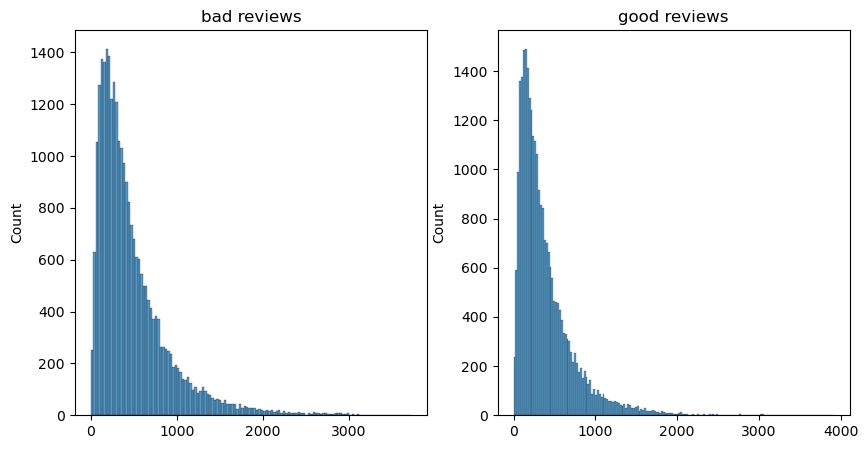

In [7]:
bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
sns.histplot(x = bad_reviews, label = 'bad reviews', ax = ax1)
ax1.set_title('bad reviews')
sns.histplot(x = good_reviews, label = 'good reviews', ax = ax2)
ax2.set_title('good reviews')
plt.show()

review
2    28094
1    27906
Name: count, dtype: int64


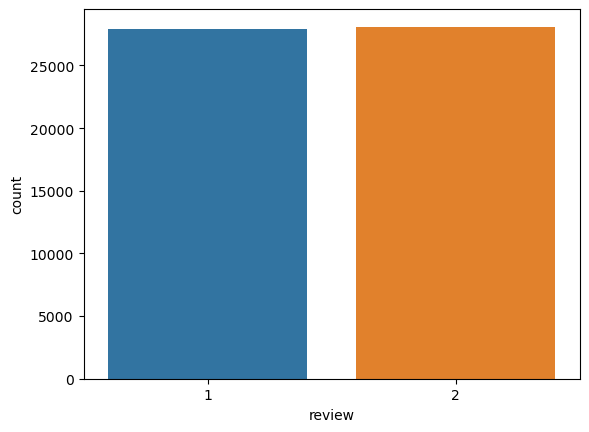

In [8]:
print(eda_df['review'].value_counts())
sns.countplot(x = eda_df['review'])
plt.show()

# Prepare data

In [14]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 256):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 5, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor([0 if label == 1 else 1 for label in labels])
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id

In [15]:
X_array = train_df['text'].apply(lambda s: clean_text(s)).values
y_array = train_df['review'].values

(train_tokens, train_ids, train_y, train_lengths), vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', train_ids.shape )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

100%|██████████| 56000/56000 [00:01<00:00, 28886.75it/s]


vocab len =  22271


100%|██████████| 56000/56000 [00:01<00:00, 43093.61it/s]


ids shape =  torch.Size([56000, 256])
y shape =  torch.Size([56000])
lengths shape =  torch.Size([56000])


In [16]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=0
tokens=['friend', 'came', 'first', 'probably', 'last', 'time', 'saw', 'groupon', 'thought', 'would', 'cool', 'try', 'vegan', 'food', 'place', 'small', 'almost', 'looks', 'like', 'movie', 'taking', 'place', 'old', 'mexico', 'outside', 'beside', 'point', 'entered', 'open', 'minds', 'upon', 'seeing', 'inside', 'restaurant', 'noticed', 'entire', 'place', 'tables', 'tops', 'wondered', 'reservation', 'required', 'woman', 'register', 'seated', 'us', 'mention', 'reservation', 'worry', 'nwhile', 'looking', 'menu', 'tall', 'overbearing', 'latin', 'woman', 'chef', 'type', 'attire', 'came', 'table', 'next', 'us', 'man', 'dressed', 'also', 'chef', 'took', 'minute', 'realize', 'owner', 'head', 'chef', 'reprimanding', 'chef', 'portion', 'size', 'using', 'customers', 'living', 'examples', 'front', 'customers', 'eating', 'food', 'strange', 'uncomfortable', 'customers', 'unprofessional', 'general', 'ni', 'ordered', 'wrap', 'said', 'come', 'either', 'chili', 'side', 'salad', 'soup', 'told', 'soup

# Model

In [17]:
class PositionalEncoding(nn.Module):

    def __init__(self, num_hiddens: int, dropout:float = 0, max_len: int = 5000):
        super().__init__()
        assert num_hiddens % 2 == 0, f'num hiddens ({num_hiddens}),has to be even'

        self.dropout = nn.Dropout(dropout)

        self.P = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len).float().unsqueeze(1)
        #N = 10000 as defined in the Attention is All You Need paper
        denom = torch.pow(10000, torch.arange(0, num_hiddens,2).float()/num_hiddens)
        x = x/denom
        self.P[:,:,0::2] = torch.sin(x)
        self.P[:,:,1::2] = torch.cos(x)

        # self.P = self.P.to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # assert x.device == self.P.device, 'in positional encoding, X should have the same device with P'
        batch_size, length, num_hiddens = x.shape
        x = x + self.P[:,:length,:].to(x.device)
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_class, 
    num_heads, dim_fc, num_tokens, 
    dropout = 0.2, num_encoder_layers = 2, batch_first = True):

        '''
        @params:
            input_size: input features or embedding size
            num_heads: number of multi attentino heads 
            dim_fc:  dimension of feedforward layer
            dropout: drop out rate
            num_tokens: number of tokens in vocabulary (some call vocab_size)
        '''
        super().__init__()

        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.encoder_layers = nn.TransformerEncoderLayer(
            d_model = input_size,
            nhead = num_heads,
            dim_feedforward= dim_fc,
            dropout = dropout,
            batch_first=batch_first,
        )

        self.encoder = nn.TransformerEncoder(encoder_layer=self.encoder_layers, num_layers = num_encoder_layers)
        self.embedding = nn.Embedding(num_tokens, input_size)
        self.input_size = input_size 

        self.fc = nn.Linear(input_size, num_class) 

        self._init_weights()
    
    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def forward(self, src, mask = None):
        batch_size, input_len = src.shape
        
        src = self.embedding(src)
        src = src * math.sqrt(self.input_size)
        src = self.pos_encoder(src)

        if mask == None:
            mask = nn.Transformer.generate_square_subsequent_mask(input_len).to(src.device)

        transformer_output = self.encoder(src, mask)

        # print('transformer output shape = ', transformer_output.shape)
        output = self.fc(transformer_output[:,-1]) 
        # print('fc output shape = ', output.shape)
        return output

In [18]:
input_size = 100 
num_class = 2
num_heads = 5
fc_hidden_size = 5
num_tokens = 1000
    
clf = TransformerClassifier(input_size, num_class, num_heads, fc_hidden_size, num_tokens, device = DEVICE)
clf.to(DEVICE)
# clf.convert_to_device(DEVICE)
X = torch.randint(0,1000,(10,5)).to(DEVICE)

y = clf(X, None)

In [19]:
class YelpReview(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]

NUM_CLASSES = len(set(list(train_y.tolist())))

train_dataset = YelpReview(train_ids, train_y, train_lengths)

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset,[train_len, val_len])


BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))

num class =  2
train dataset len =  44800
train dataloader len =  1400
val dataset len =  11200
val dataloader len =  350


In [20]:
# test model running on dataloader

(sample_ids, sample_y, sample_lengths) = next(iter(train_dataloader)) 
print('id shape = ', sample_ids.shape)
print('label shape = ', sample_y.shape)
print('lengths shape = ', sample_lengths.shape)


id shape =  torch.Size([32, 256])
label shape =  torch.Size([32])
lengths shape =  torch.Size([32])


# Tune function

In [22]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.to(device)
    model.train()
    epoch_losses = []
    epoch_accs = []

    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        label = label.to(device)
        length = length
        # prediction = model(ids, length)
        prediction = model(ids)

        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

        

def evaluate(dataloader, model, criterion, device, earlyStopping):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    max_consecutive = 0
    consecutive_count = 0
    previous_number = float('inf')
    
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        # prediction = model(ids, length)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        if earlyStopping:
            if loss < previous_number:
                previous_number = loss
                consecutive_count = 0
            else:
                consecutive_count += 1
                max_consecutive = max(max_consecutive, consecutive_count)
                if max_consecutive == 3:
                    print("\nStopping training as Validation Loss stopped improving.")
                break
            
        if earlyStopping:
            if max_consecutive == 5:
                break
            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def tune(model, optimizer, criterion, device, epochs = 10, earlyStopping=False):
    print(f"The model has {model.count_parameters()} trainable parameters")

    criterion = criterion.to(device)
    best_valid_loss = float("inf")
    history = []

    history = collections.defaultdict(list)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device, earlyStopping)
        # test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        # history["test_losses"].append(test_loss)
        # history["test_accs"].append(test_acc)
        # if test_loss < best_valid_loss:
        #     best_valid_loss = test_loss
        #     torch.save(model, f"lstm.checkpoint.pt")
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        # print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

    return history

def plot(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))
    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    # sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    # sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

# Pretrained embedding

In [23]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

# Run transformers

### Dropout Rate

output dim =  2
The model has 7885394 trainable parameters


training...:   0%|          | 0/1400 [00:00<?, ?it/s]

evaluating...: 100%|██████████| 350/350 [00:03<00:00, 112.90it/s]


epoch: 0
train_loss: 0.361, train_acc: 0.843
val_loss: 0.361, valid_acc: 0.880


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 115.09it/s]


epoch: 1
train_loss: 0.269, train_acc: 0.888
val_loss: 0.333, valid_acc: 0.885


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 114.06it/s]


epoch: 2
train_loss: 0.241, train_acc: 0.901
val_loss: 0.364, valid_acc: 0.897


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 115.03it/s]


epoch: 3
train_loss: 0.221, train_acc: 0.911
val_loss: 0.448, valid_acc: 0.896


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 115.43it/s]


epoch: 4
train_loss: 0.210, train_acc: 0.917
val_loss: 0.357, valid_acc: 0.903


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 116.07it/s]


epoch: 5
train_loss: 0.195, train_acc: 0.924
val_loss: 0.421, valid_acc: 0.901


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 114.01it/s]


epoch: 6
train_loss: 0.185, train_acc: 0.927
val_loss: 0.477, valid_acc: 0.897


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 114.10it/s]


epoch: 7
train_loss: 0.174, train_acc: 0.932
val_loss: 0.425, valid_acc: 0.900


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 111.34it/s]


epoch: 8
train_loss: 0.168, train_acc: 0.935
val_loss: 0.416, valid_acc: 0.900


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 109.24it/s]


epoch: 9
train_loss: 0.162, train_acc: 0.937
val_loss: 0.543, valid_acc: 0.896


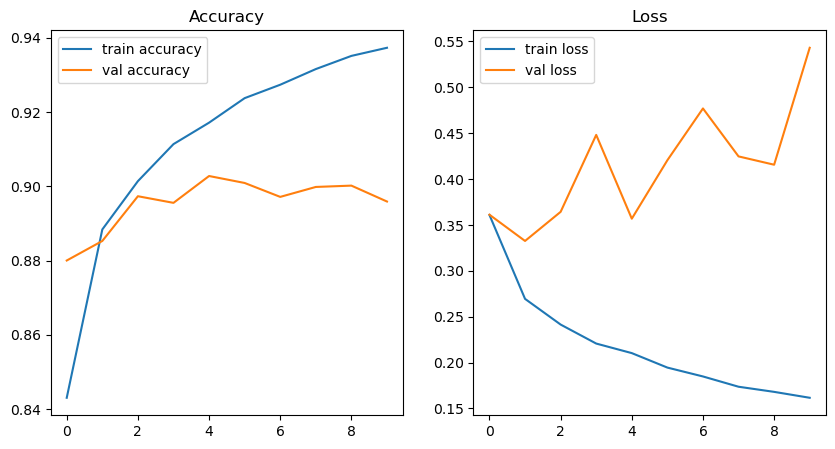

In [26]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5



model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 64,
    num_tokens = vocab_size,
    device = DEVICE,
    dropout = dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = 10, device = DEVICE, earlyStopping = False)

plot(history)

### Dropout Rate + L2 Regularization

output dim =  2
The model has 7885394 trainable parameters


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 112.74it/s]


epoch: 0
train_loss: 0.356, train_acc: 0.846
val_loss: 0.353, valid_acc: 0.870


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 109.63it/s]


epoch: 1
train_loss: 0.276, train_acc: 0.885
val_loss: 0.307, valid_acc: 0.894


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 109.04it/s]


epoch: 2
train_loss: 0.257, train_acc: 0.895
val_loss: 0.274, valid_acc: 0.897


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 111.13it/s]


epoch: 3
train_loss: 0.241, train_acc: 0.903
val_loss: 0.293, valid_acc: 0.889


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 112.88it/s]


epoch: 4
train_loss: 0.233, train_acc: 0.907
val_loss: 0.259, valid_acc: 0.906


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 111.14it/s]


epoch: 5
train_loss: 0.222, train_acc: 0.914
val_loss: 0.296, valid_acc: 0.898


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 109.23it/s]


epoch: 6
train_loss: 0.214, train_acc: 0.916
val_loss: 0.283, valid_acc: 0.905


evaluating...: 100%|██████████| 350/350 [00:05<00:00, 69.41it/s] 


epoch: 7
train_loss: 0.206, train_acc: 0.918
val_loss: 0.286, valid_acc: 0.906


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 113.83it/s]


epoch: 8
train_loss: 0.199, train_acc: 0.922
val_loss: 0.253, valid_acc: 0.911


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 114.12it/s]


epoch: 9
train_loss: 0.196, train_acc: 0.923
val_loss: 0.286, valid_acc: 0.904


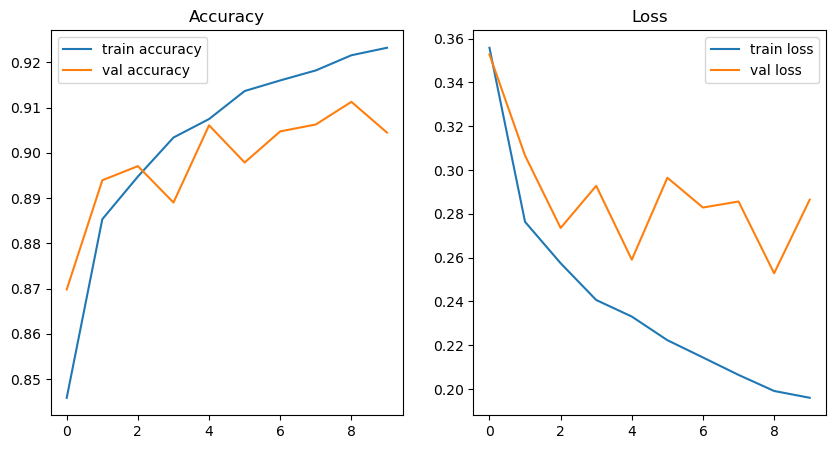

In [27]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5
weight_decay = 0.001

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 64,
    num_tokens = vocab_size,
    device = DEVICE,
    dropout = dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = 10, device = DEVICE, earlyStopping = False)

plot(history)

### Early Stopping + L2 Regularization + Dropout Rate

output dim =  2
The model has 7885394 trainable parameters


training...:   0%|          | 0/1400 [00:00<?, ?it/s]

evaluating...:   0%|          | 1/350 [00:00<00:07, 44.42it/s]


epoch: 0
train_loss: 0.410, train_acc: 0.811
val_loss: 0.466, valid_acc: 0.844


evaluating...:   0%|          | 1/350 [00:00<00:06, 52.64it/s]


epoch: 1
train_loss: 0.294, train_acc: 0.875
val_loss: 0.238, valid_acc: 0.891


evaluating...:   0%|          | 1/350 [00:00<00:06, 52.63it/s]


epoch: 2
train_loss: 0.272, train_acc: 0.885
val_loss: 0.296, valid_acc: 0.922


evaluating...:   0%|          | 1/350 [00:00<00:06, 50.00it/s]


epoch: 3
train_loss: 0.256, train_acc: 0.893
val_loss: 0.226, valid_acc: 0.922


evaluating...:   1%|          | 3/350 [00:00<00:04, 78.95it/s]


epoch: 4
train_loss: 0.245, train_acc: 0.899
val_loss: 0.257, valid_acc: 0.891


evaluating...:   0%|          | 1/350 [00:00<00:06, 55.56it/s]


epoch: 5
train_loss: 0.235, train_acc: 0.904
val_loss: 0.463, valid_acc: 0.859


evaluating...:   1%|          | 2/350 [00:00<00:04, 72.60it/s]


epoch: 6
train_loss: 0.221, train_acc: 0.909
val_loss: 0.241, valid_acc: 0.917


evaluating...:   0%|          | 1/350 [00:00<00:06, 52.63it/s]


epoch: 7
train_loss: 0.211, train_acc: 0.915
val_loss: 0.246, valid_acc: 0.953


evaluating...:   0%|          | 1/350 [00:00<00:06, 55.56it/s]


epoch: 8
train_loss: 0.203, train_acc: 0.919
val_loss: 0.385, valid_acc: 0.875


evaluating...:   0%|          | 1/350 [00:00<00:06, 55.55it/s]


epoch: 9
train_loss: 0.192, train_acc: 0.925
val_loss: 0.223, valid_acc: 0.891


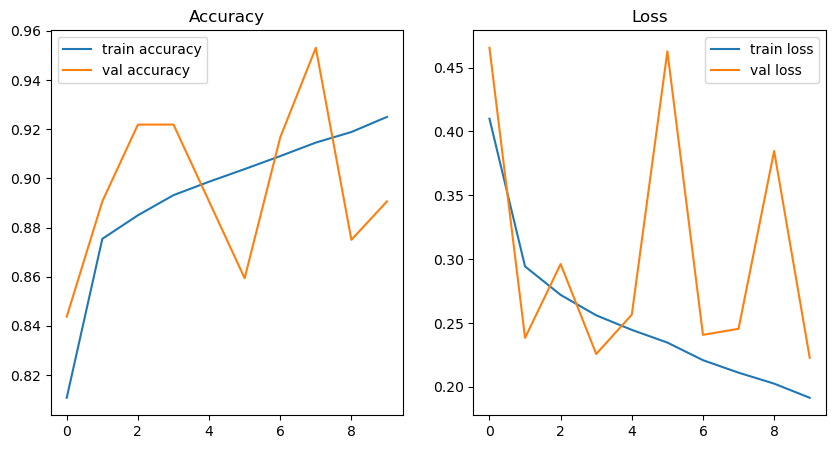

In [28]:
lr = 1e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5
weight_decay = 0.001

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 64,
    num_tokens = vocab_size,
    device = DEVICE,
    dropout=dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = 10, device = DEVICE, earlyStopping = True)

plot(history)

### Exp 2 but more epochs

In [30]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5
weight_decay = 0.001
epochs = 20

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 64,
    num_tokens = vocab_size,
    device = DEVICE,
    dropout = dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = epochs, device = DEVICE, earlyStopping = False)

plot(history)

output dim =  2
The model has 7885394 trainable parameters


training...:   0%|          | 0/1400 [00:00<?, ?it/s]

evaluating...: 100%|██████████| 350/350 [00:03<00:00, 109.28it/s]


epoch: 0
train_loss: 0.357, train_acc: 0.843
val_loss: 0.344, valid_acc: 0.877


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 110.49it/s]


epoch: 1
train_loss: 0.281, train_acc: 0.884
val_loss: 0.321, valid_acc: 0.886


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 114.78it/s]


epoch: 2
train_loss: 0.255, train_acc: 0.896
val_loss: 0.324, valid_acc: 0.892


evaluating...: 100%|██████████| 350/350 [00:02<00:00, 118.60it/s]


epoch: 3
train_loss: 0.244, train_acc: 0.902
val_loss: 0.286, valid_acc: 0.893


evaluating...: 100%|██████████| 350/350 [00:02<00:00, 120.38it/s]


epoch: 4
train_loss: 0.232, train_acc: 0.908
val_loss: 0.279, valid_acc: 0.901


evaluating...: 100%|██████████| 350/350 [00:02<00:00, 118.31it/s]


epoch: 5
train_loss: 0.222, train_acc: 0.911
val_loss: 0.286, valid_acc: 0.896


evaluating...: 100%|██████████| 350/350 [00:02<00:00, 119.65it/s]


epoch: 6
train_loss: 0.215, train_acc: 0.916
val_loss: 0.254, valid_acc: 0.911


evaluating...: 100%|██████████| 350/350 [00:02<00:00, 120.21it/s]


epoch: 7
train_loss: 0.206, train_acc: 0.920
val_loss: 0.276, valid_acc: 0.905


evaluating...: 100%|██████████| 350/350 [00:02<00:00, 119.45it/s]


epoch: 8
train_loss: 0.200, train_acc: 0.922
val_loss: 0.266, valid_acc: 0.908


evaluating...: 100%|██████████| 350/350 [00:03<00:00, 115.96it/s]


epoch: 9
train_loss: 0.195, train_acc: 0.924
val_loss: 0.298, valid_acc: 0.904


training...:  12%|█▏        | 163/1400 [00:04<00:35, 35.12it/s]


KeyboardInterrupt: 